# Matthew Makila HW4

In [8]:
import math
import pandas as pd
import copy
import time
import numpy as nump
import matplotlib.pyplot as plt

### Flower Data Processing Scripts

In [9]:
def file_import2(filename):
    """
    :param filename: for flowers
    :return: import FLOWER data
    """
    df = pd.read_csv(filename)
    X = df.iloc[:, 1:].copy()
    # X = (X - X.mean()) / X.std()
    X['x0'] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]

    X = nump.matrix(X)
    y = nump.transpose(nump.matrix(df['Species']))

    return X, y


def scaling(X):
    """
    :param X: feat matrix
    :return: SCALE TRAIN DATA
    """
    X1 = pd.DataFrame(X)

    X1 = X1.drop(0, axis='columns')
    mean = X1.mean()    # save these for later
    std = X1.std()
    X1 = (X1 - X1.mean()) / X1.std()
    X1.insert(0, 0, 1, True)
    X1 = X1.values.tolist()

    return X1, mean, std


def scaling2(X, mean, std):
    """
    :param X: feat matrix
    :param mean: train data mean
    :param std: train data std
    :return: SCALE TEST DATA
    """
    X = pd.DataFrame(X)
    X = X.drop(0, axis='columns')
    X = (X - mean) / std
    X.insert(0, 0, 1, True)
    X = X.values.tolist()
    return X

### 1A: Split Data Set into Training and Testing Data

In [10]:
X2, y_f = file_import2('flowers.csv')

# 1A, separate into test and train
y_1 = nump.transpose(nump.matrix([1 if val == 'setosa' else 0 for val in y_f]))
y_2 = nump.transpose(nump.matrix([1 if val == 'versicolor' else 0 for val in y_f]))
y_3 = nump.transpose(nump.matrix([1 if val == 'virginica' else 0 for val in y_f]))

rows = [i for i in range(X2.shape[0])]
trainRows = [i for i in range(0, 40)] + [i for i in range(50, 90)] + [i for i in range(100, 140)]
testRows = sorted(list(set.difference(set(rows), set(trainRows))))

XTrain = X2[trainRows, :]  # scale me
yTrain = y_f[trainRows, :]

y1Train = y_1[trainRows, :]
y2Train = y_2[trainRows, :]
y3Train = y_3[trainRows, :]

XTest = X2[testRows, :]  # scale me with XTrain's mean and std
yTest = y_f[testRows, :]

y1Test = y_1[testRows, :]
y2Test = y_2[testRows, :]
y3Test = y_3[testRows, :]

### 1B: Scale the Training and Test Data using Mean Normalization

In [11]:
# 1B - Scaling
XTrainScaled, X_mean, X_std = scaling(XTrain)
XTestScaled = scaling2(XTest, X_mean, X_std)

### Coding Suite for Learning Algorithms (K-Means and GDA)

In [12]:
def gradient_descent(X, y, alpha, model, lamdba):
    # create vector to hold the theta values (past and present), initialize our theta vectors to 0
    start = time.time()
    runtime = 0
    iteration_list = []
    iterations = 0
    threshold = 0.00001
    m = len(y)  # number of observations
    thetas = []
    old_thetas = []
    diff_vect = []
    costs = []
    if model == 'linear':
        for i in range(len(X)):
            thetas.append(0)
            old_thetas.append(0)
            diff_vect.append(0)
    else:
        thetas = nump.zeros(len(X[0]))
        old_thetas = nump.zeros(len(X[0]))
        diff_vect = nump.zeros(len(X[0]))
    not_converged = True
    true_count = 0
    while not_converged:
        # loop over GDA equation algorithm
        for j in range(len(thetas)):    # loop to update each feature
            g_sum = 0
            for i in range(m):  # loop to compute each summation over all observations
                h_theta_x = 0
                if model == 'linear':
                    for n in range(len(thetas)):
                        h_theta_x += (old_thetas[n] * X[n][i])
                elif model == 'cancer':
                    p = -1 * (nump.dot(old_thetas, nump.array(X[i])))
                    h_theta_x = (1 / (1 + math.exp(p)))
                else:
                    p = -1 * (nump.dot(old_thetas, X[i]))
                    h_theta_x = (1 / (1 + math.exp(p)))
                if model == 'linear':
                    g_sum += (X[j][i] * (h_theta_x - y[i]))
                else:
                    g_sum += (X[i][j] * (h_theta_x - y[i]))
            # add back to new theta here
            if lamdba == 0:
                thetas[j] = old_thetas[j] - (alpha / m) * g_sum
            else:   # we are doing regularization
                if j == 0:  # treat j = 0 without reg
                    thetas[j] = old_thetas[j] - (alpha / m) * g_sum
                else:
                    thetas[j] = (old_thetas[j] * (1 - (alpha * lamdba) / m)) - (alpha / m) * g_sum

        # check differences of new thetas will old thetas & check threshold
        for i in range(len(thetas)):
            diff_vect[i] = abs(thetas[i] - old_thetas[i])
            if diff_vect[i] < threshold:
                true_count += 1

        # if all differences are less than threshold, we converged
        if true_count == len(diff_vect):
            not_converged = False
            end = time.time()
            runtime = end-start
        else:
            # update old thetas to continue GDA next iteration
            true_count = 0
            for i in range(len(thetas)):
                old_thetas[i] = thetas[i]
    return thetas, runtime, costs, iteration_list


def k_means_cluster(k, X, plot_op1):
    rng = nump.random.default_rng(1)    # keep rand generation same
    X = nump.array(X)  # make array for ease
    m = len(X)
    # include loop to run 100 times & calculate distortions
    d_val = 0
    distortions = []
    final_distort_centroid = []
    final_distort_clusters = []
    for run in range(100):
        centroids = []
        converged = False
        for i in range(k):
            rand_int = rng.integers(0, m - 1, 1)
            centroids.append(X[rand_int[0]])
        while not converged:
            clusters = [[] for i in range(k)]   # our cluster groupings
            for j in range(m):
                cmp_dist = []
                for j1 in range(k):
                    # check euclid dist from ex to each centroid
                    e_dist = (nump.linalg.norm(X[j] - centroids[j1])) ** 2
                    cmp_dist.append(e_dist)

                # assign example to a cluster based on closest centroid
                least_dist = min(cmp_dist)
                closest_centroid = cmp_dist.index(least_dist)
                clusters[closest_centroid].append(X[j])
            # make new centroids the avg of examples in that centroid's cluster
            old_centroids = centroids
            # be careful of having an empty cluster
            centroids = [nump.mean(h, axis=0) if h else nump.zeros(len(X[0])) for h in clusters]

            if nump.equal(old_centroids, centroids).all():
                converged = True
        # do a distortion calculation after our algorithm finishes a full clustering
        d_val = distortion(centroids, clusters)
        distortions.append(d_val)
        if min(distortions) == d_val:
            # pick centroids, clusters from run of alg for which distortion is min
            final_distort_centroid = centroids
            final_distort_clusters = clusters
    if plot_op1:
        plot_distortion_v_run(distortions)  # plot distortion vs. run
    return final_distort_clusters, final_distort_centroid, d_val


def distortion(centroids, clusters):
    k = len(centroids)
    c_totals = 0
    for i in range(k):
        # loop over every cluster and sum euclid distances for each ex from its centroid
        e_dist = 0
        m = len(clusters[i])
        for j in range(m):
            e_dist += (nump.linalg.norm(centroids[i] - clusters[i][j])) ** 2
        c_totals += e_dist
    total_m = 0
    for i in range(k):
        total_m += len(clusters[i])
    return c_totals / total_m


def plot_distortion_v_run(distortions):
    run = [i for i in range(100)]
    plt.plot(run, distortions)
    plt.title("Distortion vs. Run")
    plt.ylabel("J (Distortion)")
    plt.xlabel("Run")
    plt.show()


def assign_new_k_mean(new_examples, old_centroids):
    k = len(old_centroids)
    new_clust = [[] for i in range(k)]  # cluster groupings
    for i in range(len(new_examples)):
        cmp_dist = []
        for j in range(k):
            # check euclid dist from ex to each centroid
            e_dist = (nump.linalg.norm(new_examples[i] - old_centroids[j])) ** 2
            cmp_dist.append(e_dist)
        # assign example to a cluster based on closest centroid
        least_dist = min(cmp_dist)
        closest_centroid = cmp_dist.index(least_dist)
        new_clust[closest_centroid].append(new_examples[i])
    return new_clust


def confusion_centroids(f_centroids):
    df = pd.DataFrame(f_centroids)
    df = df.drop(0, axis='columns')
    df.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
    df.index = ['Cluster 1', 'Cluster 2', 'Cluster 3']
    print(df)
    return


def k_means_confusion(x, clusters):
    # compare the scaled x's (just like response mat since it's still ordered) to our clusters
    x = nump.array(x)
    new_y = []
    clust_range = len(x) // len(clusters)
    y_hat = []
    # break up each cluster for cross-check
    c_num = 0
    for clus in clusters:
        c_num += 1
        for i in range(len(clus)):
            y_hat.append("Cluster {}".format(c_num))
    # check which examples in the clusters match the response (or ordered x mat)
    for clus in clusters:
        for i in range(len(clus)):
            for j in range(len(x)):
                # search all of x (in 3 flower intervals) for specific ex in a cluster matching an actual flower result
                if nump.array_equal(clus[i], x[j]):
                    if j < clust_range:
                        new_y.append('Setosa')
                    elif clust_range <= j < clust_range*2:
                        new_y.append('Versicolor')
                    elif j >= clust_range*2:
                        new_y.append('Virginica')
    confuse = pd.crosstab(new_y, y_hat, margins=True)
    print(confuse)
    return

### 1C: K-Means Clustering (with k = 3)

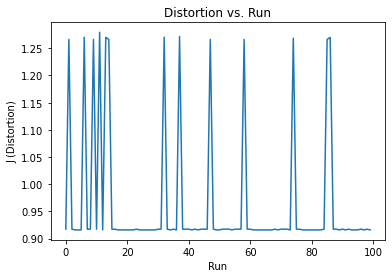

In [16]:
# 1C - k means (k = 3)
clust, centroids, distort_v = k_means_cluster(3, XTrainScaled, True)

##### The above graph details the distortion values plotted against the 100 runs to ensure there are enough iterations to choose the centroids and clusters corresponding to the minimum distortion

In [17]:
print("\nThe resulting k-means centroids:\n")
confusion_centroids(centroids)
print("\nTraining data: Response vs. Cluster Assignment:\n")
k_means_confusion(XTrainScaled, clust)


The resulting k-means centroids:

           Sepal Length  Sepal Width  Petal Length  Petal Width
Cluster 1     -1.007815     0.873569     -1.301589    -1.265071
Cluster 2     -0.097303    -0.934566      0.335813     0.312792
Cluster 3      1.075790     0.036715      0.950411     0.936681

Training data: Response vs. Cluster Assignment:

col_0       Cluster 1  Cluster 2  Cluster 3  All
row_0                                           
Setosa             40          0          0   40
Versicolor          0         28         12   40
Virginica           0         11         29   40
All                40         39         41  120


##### The first table above depicts the final chosen centroids from the k-means clustering algorithm, with k = 3. The second table shows the response (actual flowers) vs. cluster assignment (how they were clustered) matrix. These centroids and clusters were chosen based upon the algorithm run with the minimum distortion for the most accuracy. 

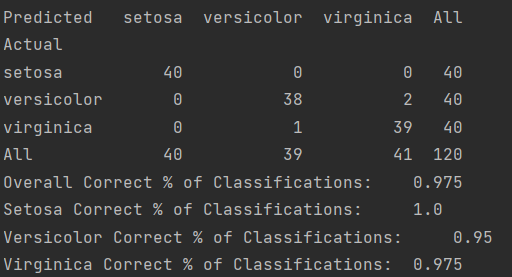

##### The above confusion matrix from HW2 3D differs from our response vs. cluster assignment matrix primarily due to the accuracy of the classifications. In the prior HW assignment, the data had labels and so training was based upon these known labels, so it is not surprising that classifications would be more accurate. In this assignment, the learning was unsupervised without labels and still provided decent accuracy and clustered data well considering it had no prior labels. 

### 1D: K-Means Clustering (k = 3) for Testing Data

In [18]:
# 1D
# call function for assigning new examples (test data) into clusters using final centroids
# then call k_means_confusion again with new testing clusters and XTestScaled
print("\nTesting data: Response vs. Cluster Assignment:\n")
test_clusters = assign_new_k_mean(XTestScaled, centroids)
k_means_confusion(XTestScaled, test_clusters)


Testing data: Response vs. Cluster Assignment:

col_0       Cluster 1  Cluster 2  Cluster 3  All
row_0                                           
Setosa             10          0          0   10
Versicolor          0         10          0   10
Virginica           0          3          7   10
All                10         13          7   30


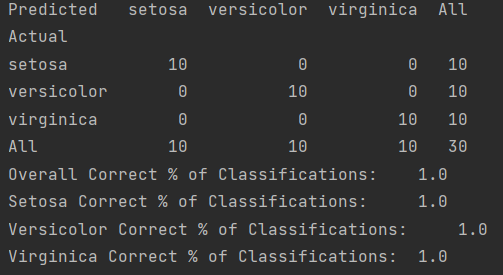

##### The above confusion matrix from HW2 3E differs from our response vs. cluster assignment matrix for testing data primarily due to the accuracy of the classifications. The new examples were classified into clusters based on their minimum euclidean distance to the existing centroids found from the training data. In the prior HW assignment, the data had labels and so training was based upon these known labels, and classifications were perfect. In this assignment, the learning was unsupervised without labels and still provided decent accuracy and clustered data well considering it had no prior labels, just as with the training data. 

### 2: Plotting the K-Means Clustering Distortions per Number of Cluster

In [20]:
def plot_elbow(data):
    d_list = []
    for i in range(5):
        clust1, centroids1, distort_val = k_means_cluster(i + 1, data, False)
        d_list.append(distort_val)
    k_ = [i + 1 for i in range(5)]
    plt.plot(k_, d_list)
    plt.title("Distortion by (K) Number of Clusters")
    plt.ylabel("J (Distortion)")
    plt.xlabel("K (number of clusters)")
    plt.show()

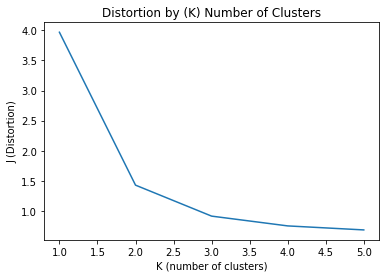

In [21]:
# 2, Plot elbow graph
plot_elbow(XTrainScaled)

##### The above graph plots the distortion recorded per the number of clusters. Where we see an elbow form soonest after the steeper part of the graph where distortion is near minimum is usually our best indicator of the optimal number of clusters (in this case k = 3)

### 3A & 3B: Use the PCA Algorithm for Training Data

In [22]:
def pca(x):
    m = len(x)
    # drop the 1's column
    x = pd.DataFrame(x)
    x = x.drop(0, axis='columns')
    x = nump.array(x)
    # step 1: calculate sigma (sample covariance)
    s_cov_mat = (1 / m) * (nump.matmul(nump.transpose(x), x))

    # step 2: get eigenvalues and eigenvectors
    eig_vals, eig_vects = nump.linalg.eig(s_cov_mat)

    # step 3: get first 2 principal components
    U_red = nump.transpose(eig_vects)
    U_red = U_red[:2]

    # step 4: define z feature vector
    z_feat = []
    for i in range(m):
        z_feat.append(nump.matmul(U_red, x[i]))
    z_feat = pd.DataFrame(z_feat)
    # print the scatter plot of data
    p_range = m // 3
    plt.plot(z_feat[0][:p_range], z_feat[1][:p_range], "o", label='Setosa', c='orange')
    plt.plot(z_feat[0][p_range:p_range*2], z_feat[1][p_range:p_range*2], "o", label='Versicolor', c='blue')
    plt.plot(z_feat[0][p_range*2:p_range*3], z_feat[1][p_range*2:p_range*3], "o", label='Virginica', c='green')
    plt.legend()
    plt.ylabel("Z2")
    plt.xlabel("Z1")
    plt.title("PCA Scatter-plot")
    plt.show()

    return z_feat, U_red

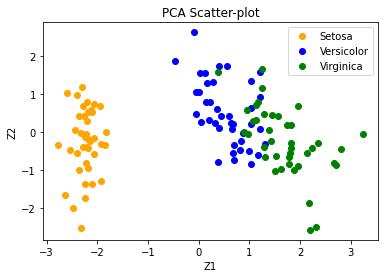

In [25]:
zTrain, U = pca(XTrainScaled)

##### The above scatter plot details visually the results of the PCA algorithm on the training data. The data already has experienced some clustering for Setosa, Versicolor, and Virginica when Z1 and Z2 are plotted against each other, even with the features reduced. 

In [26]:
print("\nThe first two principal components:\n")
U1 = pd.DataFrame(nump.transpose(U))
U1.columns = ['U1', 'U2']
print(U1)
print("\nThe new Z feature matrix:\n")
zTrain.columns = ['Z1', 'Z2']
print(zTrain)


The first two principal components:

         U1        U2
0  0.514095 -0.402374
1 -0.289316 -0.912403
2  0.579176 -0.033473
3  0.562634 -0.067055

The new Z feature matrix:

           Z1        Z2
0   -2.274812 -0.386131
1   -2.070951  0.735245
2   -2.354952  0.421751
3   -2.286076  0.670836
4   -2.400671 -0.543811
..        ...       ...
115  2.710580 -0.870568
116  1.512367 -1.025144
117  1.289698 -0.401900
118  0.885684  0.006682
119  1.784495 -0.664476

[120 rows x 2 columns]


##### The above tables represent the first 2 principal components and the corresponding Z feature matrix. The first 2 principal components carry the most significant information from the original data. The Z feature matrix carries the observations with their newly reduced vector forms. 

### 3C: Use the PCA Algorithm for Testing Data

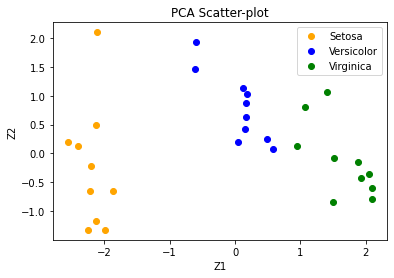

In [27]:
# 3C, do same with test data
zTest, U_ = pca(XTestScaled)

##### The above scatter plot details visually the results of the PCA algorithm on the testing data. The new examples were gathered using the PCA algorithm once again and experienced some clustering for Setosa, Versicolor, and Virginica when Z1 and Z2 are plotted against each other, even with the features reduced.

### 4A: K-Means Clustering for PCA Training Data

In [41]:
# 4A, k-means for PCA training data COMPARE TO 1C
print("\nTraining data: Response vs. Cluster Assignment:\n")
z_clust, z_centroids, z_distort_v = k_means_cluster(3, zTrain, False)
k_means_confusion(zTrain, z_clust)
print("\nThe resulting PCA k-means centroids:\n")
print(z_centroids)


Training data: Response vs. Cluster Assignment:

col_0       Cluster 1  Cluster 2  Cluster 3  All
row_0                                           
Setosa              0          0         40   40
Versicolor         29         11          0   40
Virginica          11         29          0   40
All                40         40         40  120

The resulting PCA k-means centroids:

[array([0.59804443, 0.83751149]), array([ 1.6384273 , -0.57438031]), array([-2.23647173, -0.26313118])]


##### The response vs. cluster assignment matrix in this example is just slightly improved from the matrix in 1C. They are nearly the same, but this data has been clustered with just a few more correct classifications. Setosa flowers are still classified perfectly, and the Versicolor and Virginica classifications marginally improved.

##### The new centroids from the PCA algorithm training data are also recorded

### 4B: K-Means Clustering for PCA Testing Data

In [38]:
# 4B, k-means for PCA testing data, COMPARE TO 1D
print("\nTesting data: Response vs. Cluster Assignment:\n")
z_clust1, z_centroids1, z_distort_v1 = k_means_cluster(3, zTest, False)
k_means_confusion(zTest, z_clust1)


Testing data: Response vs. Cluster Assignment:

col_0       Cluster 1  Cluster 2  Cluster 3  All
row_0                                           
Setosa              0         10          0   10
Versicolor         10          0          0   10
Virginica           3          0          7   10
All                13         10          7   30


##### The response vs. cluster assignment matrix for testing data is just slightly improved from the matrix in 1D. They are identitical tables. Setosa flowers are still classified perfectly, and the Versicolor and Virginica classifications are just as they were for the last series of testing data, with the minor exception that the clusters are labled differently (versicolor is now cluster 1, it was cluster 2 in 1D).

### 5A: Graph Training R-Squared vs. LOOCV R-Squared for the first K-Mean Features

In [36]:
def file_import(f_name):
    """
    param f_name: for mileage
    :return: import MILEAGE
    """
    # specify features and the response var for file extraction and storage as a table
    feat_names = ['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
    f_feat_names = ['x0', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
    df = pd.read_csv(f_name, usecols=feat_names)
    resp_vect = df['mpg'].values.tolist()

    # scale the features
    scale_df = ((df - df.mean()) / df.std())

    # add vector for x0 of 1's; remove the response var
    x_0 = []
    for i in range(len(resp_vect)): x_0.append(1)
    scale_df = scale_df.drop('mpg', axis='columns')
    scale_df.insert(0, "x0", x_0, True)

    # create feature matrix to store all scaled features

    feat_matrix = []
    for feat in f_feat_names:
        feat_matrix.append(scale_df[feat].values.tolist())
    return feat_matrix, resp_vect


def k_feat_calc(X, y, alpha, lamb):
    y_hat = []
    y_hat2 = []
    n = len(X)
    for i in range(n + 1):
        theta, run, cost, it = gradient_descent(X[:i + 1], y, alpha, 'linear', lamb)  # with 1 left out
        y_hat_L = LOOCV(X[:i + 1], y, alpha, lamb)
        y_hat.append(nump.dot(theta, X[:i + 1]))
        y_hat2.append(y_hat_L)
    y_hat.pop(0)    # destroy first set
    y_hat2.pop(0)
    k_calc_errors(y, y_hat, y_hat2, X)


def LOOCV(X, y, alpha, lamb):
    m = len(y)
    n = len(X)
    y_hat = []
    theta = []
    feat_to_predict = []
    for i in range(m):
        # remember original intact matrices for X and y while we remove 1 at a time
        n_X = copy.deepcopy(X)
        n_y = copy.deepcopy(y)
        # begin removals
        feat_to_predict = []
        n_y.pop(i)
        for j in range(n):  # save & remove all features of a specific example to predict later
            feat_to_predict.append(n_X[j][i])
            n_X[j].pop(i)
        theta, run, cost, it = gradient_descent(n_X, n_y, alpha, 'linear', lamb)   # with 1 left out
        y_hat.append(nump.dot(theta, feat_to_predict))
    return y_hat


def k_calc_errors(y, y_hat, y_hat2, X):
    Rs = []
    LOOCV_Rs = []
    for i in range(len(X) - 1):
        error = nump.array(y) - nump.array(y_hat[i]).T
        error_LOOCV = nump.array(y) - nump.array(y_hat2[i]).T
        # calculate R^2 for reg
        SSR = sum(pow(error, 2))
        SST = sum(pow((nump.array(y) - nump.array(nump.mean(y)).T), 2))
        R_Sq = 1 - (SSR / SST)
        # calculate R^2 for LOOCV
        SSR_ = pow(error_LOOCV, 2)
        SST_ = pow((nump.array(y) - nump.array(nump.mean(y)).T), 2)
        LOOCV_R_Sq = 1 - (sum(SSR_) / sum(SST_))
        Rs.append(R_Sq)
        LOOCV_Rs.append(LOOCV_R_Sq)
    plot_rs(Rs, LOOCV_Rs)


def plot_rs(R, LOOCV_R):
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    plt.plot(x, R, label='Training R-Squared')
    plt.plot(x, LOOCV_R, label='LOOCV R-Squared')
    plt.legend()
    plt.title("First k-features Training R-Squared and LOOCV R-Squared")
    plt.ylabel("R-Squared Values")
    plt.xlabel("Number of features")
    plt.show()

    
def reg_r_plot(X, y, alpha):
    y_hat = []
    y_hat2 = []
    lambs = nump.linspace(0, 10, num=101)   # our set of 101 different lambdas
    for i in range(len(lambs)):     # yes, run 101 times for each lambda
        theta, run, cost, it = gradient_descent(X, y, alpha, 'linear', lambs[i])
        y_hat_L = LOOCV(X, y, alpha, lambs[i])
        y_hat.append(nump.dot(theta, X))
        y_hat2.append(y_hat_L)
    # calculate the R-squared vals
    Rs = []
    LOOCV_Rs = []
    for i in range(101):
        error = nump.array(y) - nump.array(y_hat[i]).T
        error_LOOCV = nump.array(y) - nump.array(y_hat2[i]).T
        # calculate R^2 for reg
        SSR = sum(pow(error, 2))
        SST = sum(pow((nump.array(y) - nump.array(nump.mean(y)).T), 2))
        R_Sq = 1 - (SSR / SST)
        # calculate R^2 for LOOCV
        SSR_ = pow(error_LOOCV, 2)
        SST_ = pow((nump.array(y) - nump.array(nump.mean(y)).T), 2)
        LOOCV_R_Sq = 1 - (sum(SSR_) / sum(SST_))
        Rs.append(R_Sq)
        LOOCV_Rs.append(LOOCV_R_Sq)
    # plot the R-squared values
    plt.plot(lambs, Rs, label='Training R-Squared')
    plt.plot(lambs, LOOCV_Rs, label='LOOCV R-Squared')
    plt.legend()
    plt.title("Training R-Squared vs. LOOCV R-Squared with Regularization")
    plt.ylabel("R-Squared Values")
    plt.xlabel("Lambda (Regularization Parameter)")
    plt.show()

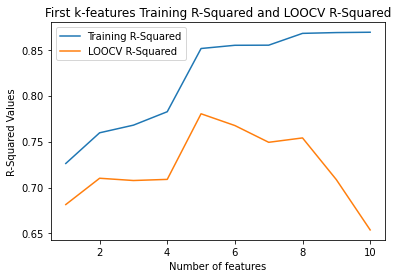

In [37]:
X_, y_ = file_import('mileage.csv')
a = 0.2
k_feat_calc(X_, y_, a, 0)

### 5B: Interpret the above plot

##### In the above graph, we can see that the training R-Squared values increase as the number of features increase. However, the LOOCV R-Squared values increase up until we use 5 features, at which point there is a steady decline in the LOOCV R-Squared values. This tells us that after a certain amount of added features, we are hurting our ability to classify test data. 

### 5C: Graph the Training R-Squared vs. LOOCV R-Squared with Regularization

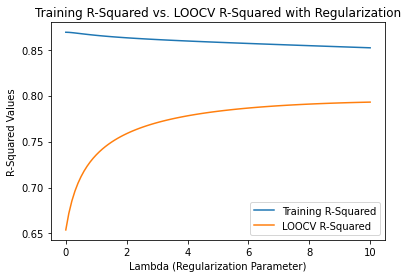

In [34]:
# 5C, Graph Training R-Squared vs. LOOCV R-Squared with Regularization
reg_r_plot(X_, y_, a)

### 5D: Interpret the above plot

##### In the graph above, we notice a steady increase in the LOOCV R-Squared values as we increase our regularization parameter. The training R-Squared steadily decreases as we increase regularization. This approaches the ideal scenario where the difference between training R-Squared and LOOCV R-Squared are minimum.